In [1]:
# from lib.mlggm.datamodules import ApneaDataModule

In [2]:
# dm = ApneaDataModule(batch_size=1024, num_workers=4, shuffle=False, path="./data")

## Load data and split into train, val, test sets

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from lib import models, graph, coarsening, utils
import scipy

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
data = np.load(os.path.join("./data", "apnea_data.npz"))
X, y = data['samples'], data['labels']

In [3]:
X = np.transpose(X)
X.shape

(17010, 6000)

In [4]:
y.shape

(17010,)

In [5]:
X = X.astype('float32')

In [19]:
X.dtype

dtype('float32')

In [6]:
d = X.shape[-1]
n = len(y)

In [7]:
n_train = n // 2
n_val = n // 10

X_train = X[:n_train]
X_val   = X[n_train:n_train+n_val]
X_test  = X[n_train+n_val:]

y_train = y[:n_train]
y_val   = y[n_train:n_train+n_val]
y_test  = y[n_train+n_val:]

In [8]:
X_train.shape

(8505, 6000)

In [9]:
y_train.shape

(8505,)

In [10]:
X_val.shape

(1701, 6000)

In [11]:
y_val.shape

(1701,)

In [12]:
X_test.shape

(6804, 6000)

In [13]:
y_test.shape

(6804,)

In [20]:
# make adjacency matrix: v_i <-> v_i+1
A = np.zeros((d,d))
diag = np.ones((d-1,))
np.fill_diagonal(A[:-1, 1:], diag)
np.fill_diagonal(A[1:, :-1], diag)
# A = np.diag(diag, k=1)

In [21]:
A

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [23]:
A = A.astype('float32')

In [24]:
A = scipy.sparse.csr_matrix(A)

In [25]:
A

<6000x6000 sparse matrix of type '<class 'numpy.float32'>'
	with 11998 stored elements in Compressed Sparse Row format>

In [26]:
assert A.shape == (d, d)

In [19]:
# Coarsening
graphs, perm = coarsening.coarsen(A, levels=3, self_connections=False)

X_train = coarsening.perm_data(X_train, perm)
X_val = coarsening.perm_data(X_val, perm)
X_test = coarsening.perm_data(X_test, perm)

Layer 0: M_0 = |V| = 8512 nodes (2512 added),|E| = 5999 edges
Layer 1: M_1 = |V| = 4256 nodes (909 added),|E| = 3346 edges
Layer 2: M_2 = |V| = 2128 nodes (247 added),|E| = 1880 edges
Layer 3: M_3 = |V| = 1064 nodes (0 added),|E| = 1064 edges


Computing laplacian...
Computing laplacian...
Computing laplacian...
Computing laplacian...
Plotting spectrum
Laplacian  0
Computed fourier
Laplacian  1
Computed fourier
Laplacian  2
Computed fourier
Laplacian  3
Computed fourier


/home/agarmanv/Documents/cnn_graph/cnn_venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


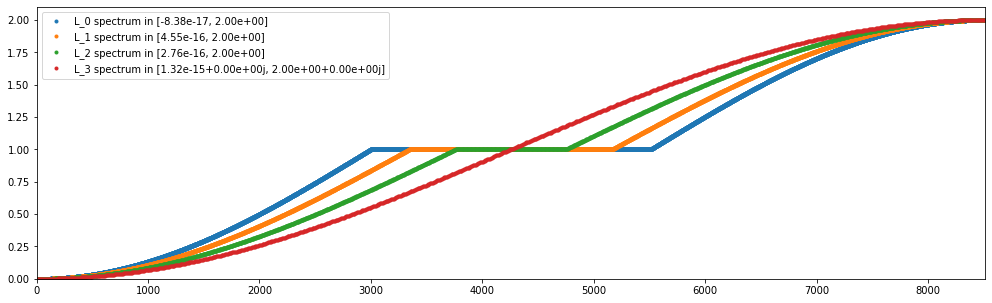

In [20]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)

In [27]:
# Coarsening
graphs, perm = coarsening.coarsen(A, levels=6, self_connections=False)

X_train = coarsening.perm_data(X_train, perm)
X_val = coarsening.perm_data(X_val, perm)
X_test = coarsening.perm_data(X_test, perm)

Layer 0: M_0 = |V| = 12288 nodes (6288 added),|E| = 5999 edges
Layer 1: M_1 = |V| = 6144 nodes (2794 added),|E| = 3349 edges
Layer 2: M_2 = |V| = 3072 nodes (1186 added),|E| = 1885 edges
Layer 3: M_3 = |V| = 1536 nodes (474 added),|E| = 1062 edges
Layer 4: M_4 = |V| = 768 nodes (168 added),|E| = 600 edges
Layer 5: M_5 = |V| = 384 nodes (44 added),|E| = 340 edges
Layer 6: M_6 = |V| = 192 nodes (0 added),|E| = 192 edges


In [28]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
# graph.plot_spectrum(L)

Computing laplacian...
Computing laplacian...
Computing laplacian...
Computing laplacian...
Computing laplacian...
Computing laplacian...
Computing laplacian...


In [29]:
# Number of classes.
C = y.max() + 1
assert C == np.unique(y).size

In [30]:
C

2

In [31]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 40
params['batch_size']     = 1024
params['eval_frequency'] = 200

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Architecture.
params['F']              = [32, 64]  # Number of graph convolutional filters.
params['K']              = [20, 20]  # Polynomial orders.
params['p']              = [4, 2]    # Pooling sizes.
params['M']              = [512, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 1
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = n_train / params['batch_size']

In [32]:
model = models.cgcnn(L, **params)
accuracy, loss, t_step = model.fit(X_train, y_train, X_val, y_val)

NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 32 / 4 = 98304
    weights: F_0 * F_1 * K_1 = 1 * 32 * 20 = 640
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 3072 * 64 / 2 = 98304
    weights: F_1 * F_2 * K_2 = 32 * 64 * 20 = 40960
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 98304 * 512 = 50331648
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 2
    weights: M_3 * M_4 = 512 * 2 = 1024
    biases: M_4 = 2
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.


2022-06-22 14:18:40.887868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 14:18:40.959103: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11/lib64:/usr/local/cuda-11.1/lib64
2022-06-22 14:18:40.959130: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-22 14:18:40.960046: I tensorflow/core/platform/cpu_feature_guard

KeyboardInterrupt: 